In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
random_state = 2020


train_df = pd.read_csv('../data/final/train_imputed.csv')
val_df = pd.read_csv('../data/final/val_imputed.csv')
test_df = pd.read_csv('../data/final/test_imputed.csv')

X_train = train_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_train.shape)
y_train = train_df.aki_label.values

X_val = val_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_val.shape)
y_val = val_df.aki_label.values

X_test = test_df.drop(columns=['patientunitstayid', 'aki_label']).values
print(X_test.shape)
y_test = test_df.aki_label.values

(57474, 85)
(14303, 85)
(10646, 85)


In [4]:
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

learning_rate = [0.1,0.01,0.001]
n_estimators = [100, 500,1000]
max_depth = [3, 10, 50]

tested_params_gb = {'max_depth': [],
    'n_estimators': [],
    'learning_rate':[],
      'roc':[],
         'avepscore':[]}

for lr in learning_rate:
    for ne in n_estimators:
        for md in max_depth:
            gb = GradientBoostingClassifier(random_state=2020, max_depth=md,\
                                       n_estimators=ne, learning_rate=lr)
            tested_params_gb['max_depth'].append(md)
            tested_params_gb['n_estimators'].append(ne)
            tested_params_gb['learning_rate'].append(lr)
            gb.fit(X_train, y_train)
            print('training complete')
            y_pred = gb.predict_proba(X_val)[:,1]
            roc = roc_auc_score(y_val, y_pred)
            avepscore =  average_precision_score(y_val, y_pred)
            tested_params_gb['roc'].append(roc)
            tested_params_gb['avepscore'].append(avepscore)

training complete
training complete
training complete


KeyboardInterrupt: 

In [6]:
tested_params_gb['max_depth']= [3, 10, 50]
tested_params_gb['n_estimators']= [100, 100, 100]
tested_params_gb['learning_rate'] = [0.1, 0.1, 0.1]

In [7]:
pd.DataFrame(tested_params_gb)

,max_depth,n_estimators,learning_rate,roc,avepscore
0,3,100,0.1,0.873260,0.166941
1,10,100,0.1,0.862115,0.140694
2,50,100,0.1,0.599272,0.071843


In [8]:
X_train_val = np.vstack((X_train, X_val))
print(X_train_val.shape)
y_train_val = np.concatenate((y_train, y_val), axis=0)
print(y_train_val.shape)

(71777, 85)
(71777,)


In [9]:
gb = GradientBoostingClassifier(random_state=2020, max_depth=3,\
                                       n_estimators=100, learning_rate=0.1)
gb.fit(X_train_val, y_train_val)

GradientBoostingClassifier(random_state=2020)

[[10365    35]
 [  219    27]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     10400
           1       0.44      0.11      0.18       246

    accuracy                           0.98     10646
   macro avg       0.71      0.55      0.58     10646
weighted avg       0.97      0.98      0.97     10646



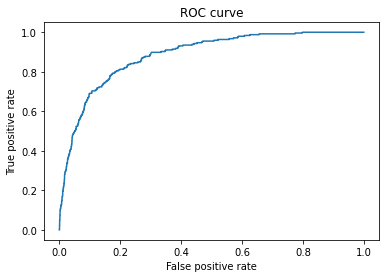

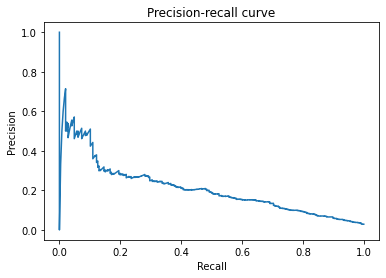

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

y_score = gb.predict(X_test)
y_pred = gb.predict_proba(X_test)[:, 1]
print(confusion_matrix(y_test, y_score))
print(classification_report(y_test, y_score))
fpr, tpr, auc_th = roc_curve(y_test, y_pred)
precision, recall, pr_th = precision_recall_curve(y_test, y_pred)

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve')
plt.show()

In [13]:
feat_imp = pd.DataFrame({'feature': train_df.drop(columns=['patientunitstayid', 'aki_label']).columns , 'importance': gb.feature_importances_})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp

,feature,importance
36,max_result_creatinine,0.418440
0,Unnamed: 0,0.141635
41,delta_result_BUN,0.051055
56,unitdischargestatus_alive,0.044129
53,delta_result_platelets x 1000,0.020064
...,...,...
66,unittype_CSICU,0.000000
65,unittype_CCU-CTICU,0.000000
64,ethnicity_Other/Unknown,0.000000
63,ethnicity_Native American,0.000000


Text(0.5, 1.0, 'Feature importance')

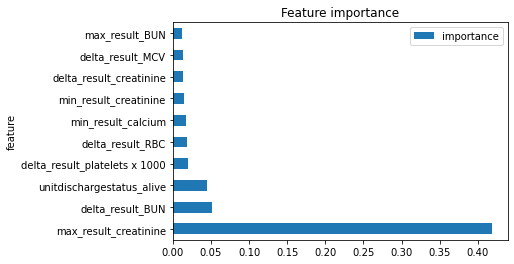

In [14]:
feat_imp = feat_imp[feat_imp['feature']!='Unnamed: 0']
feat_imp[:10].plot.barh(y='importance', x='feature')
plt.title('Feature importance')